# Get a list of URLs

Search and scroll
Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

# Download into file
Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press CtrlShiftJ in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise window.open() coomand doesn't work. Then you can run the following commands:

urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

# Create directory and upload urls file into your server

In [2]:
from fastai.vision import *

In [5]:
Path

pathlib.Path

In [22]:
folder = 'horse'
file = 'urls_horse.csv'

In [23]:
path = Path('data_lesson2/animals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [25]:
folder = 'donkey'
file = 'urls_donkey.csv'

In [26]:
path = Path('data_lesson2/animals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [10]:
folder = 'mule'
file = 'urls_mule.csv'

In [11]:
path = Path('data_lesson2/animals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [12]:
path.ls()

[PosixPath('data_lesson2/animals/donkey'),
 PosixPath('data_lesson2/animals/mule'),
 PosixPath('data_lesson2/animals/horse')]

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

# Download images

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

In [27]:
classes = ['horse','donkey','mule']

In [28]:
download_images(path/folder/file, dest, max_pics=200)

In [18]:
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [29]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [30]:
doc(verify_images)

verify_images [source] [test] verify_images ( path : PathOrStr , delete : bool = True , max_workers : int = 4 , max_size : int = None , recurse : bool = False , dest : PathOrStr = '.' , n_channels : int = 3 , interp = 2 , ext : str = None , img_format : str = None , resume : bool = None , ** kwargs ) 
 
 × Tests found for verify_images : pytest -sv tests/test_vision_data.py::test_verify_images [source] To run tests please refer to this guide . Check if the images in path aren't broken, maybe resize them and copy it in dest . 
 Show in docs

# View data

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [32]:
data.classes

['donkey', 'horse', 'mule']

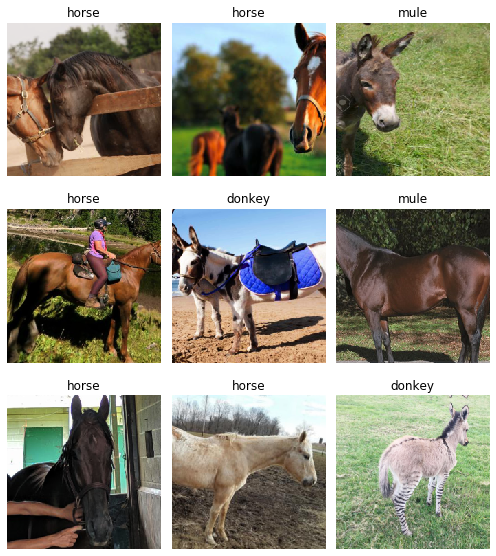

In [33]:
data.show_batch(rows=3, figsize=(7,8))

In [34]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['donkey', 'horse', 'mule'], 3, 448, 111)

# train model

In [36]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [37]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.212065,0.764668,0.324324,01:57
1,0.975144,0.547193,0.270270,01:57
2,0.819736,0.543602,0.243243,01:57
3,0.701683,0.550245,0.243243,01:58


In [38]:
learn.save('stage-1')

In [46]:
learn.unfreeze()

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


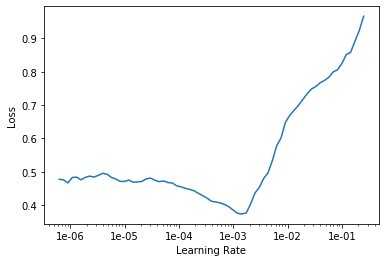

In [48]:
learn.recorder.plot()

In [ ]:
# train model with all the data
# learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

In [ ]:
# learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

In [ ]:
learn.save('stage-2')

# Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [41]:
doc(interp.top_losses)

top_losses [source] [test] top_losses ( k : int = None , largest = True ) 
 
 × No tests found for top_losses . To contribute a test please refer to this guide and this discussion . k largest(/smallest) losses and indexes, defaulting to all losses (sorted by largest ). 
 Show in docs

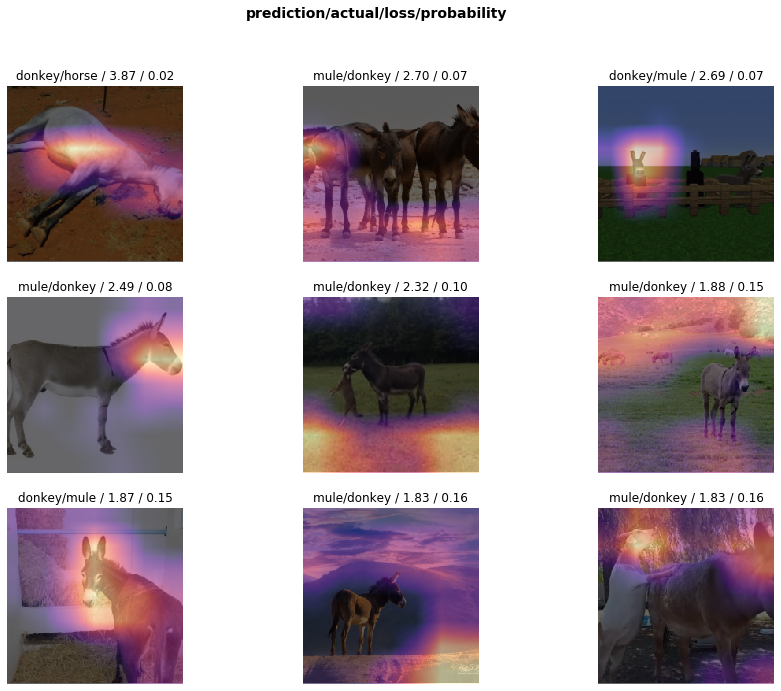

In [40]:
interp.plot_top_losses(9, figsize=(15,11))

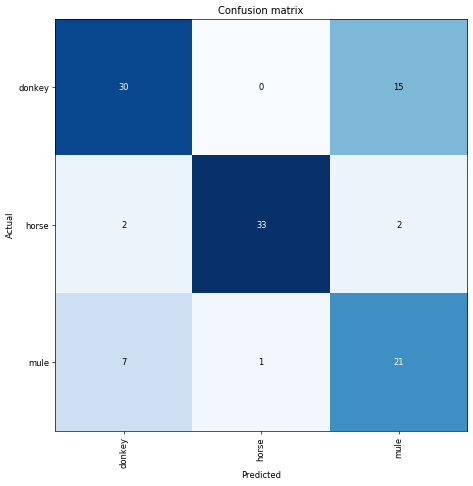

In [43]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [45]:
interp.most_confused()

[('donkey', 'mule', 15),
 ('mule', 'donkey', 7),
 ('horse', 'donkey', 2),
 ('horse', 'mule', 2),
 ('mule', 'horse', 1)]

# clean up data

after you cleaned your noisy images, you can retrain your model


So you might create a route something like this (thanks to Simon Willison for the structure of this code):


@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
    
    
(This example is for the Starlette web app toolkit.)

# Things that can go wrong

Most of the time things will train fine with the defaults
There's not much you really need to tune (despite what you've heard!)
Most likely are
Learning rate
Number of epochs